<a href="https://colab.research.google.com/github/zoebatz/CAP6640_Project/blob/main/NLP_gpt_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import openai
import pandas as pd
import numpy as np
import os
import kagglehub

from google.colab import userdata

# print(openai.__version__)
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_NLP')

In [123]:
# import data from google drive
file_name = "data_tc1"

path = "/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/"+file_name+".csv"
data = pd.read_csv(path)
data.head()



,movie_id,text,genre,label
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance,0
1,tt1798632,A young girl tries to understand how she myste...,horror,1
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy,2
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance,0
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance,0


In [124]:
len(data)

1000

In [60]:
data.value_counts('label')

,count
label,
0,250
1,250
2,250
3,250


In [61]:
zero_shot = f""" """

one_shot = f"""
              Input: "Two strangers from different worlds cross paths and form an unexpected bond. As they navigate challenges and personal doubts, they must decide if taking a leap of faith is worth the risk."
              Output: Romance
              Input: "A quiet town is shaken when an ancient evil awakens, preying on those who dare to uncover its secrets. As the darkness spreads, a small group must fight to survive before they become its next victims."
              Output: Horror
              Input: "When a series of ridiculous misunderstandings spirals out of control, an unlikely group of misfits is forced to work together. Along the way, chaos ensues, friendships are tested, and laughter is inevitable."
              Output: Comedy
              Input: "A skilled operative is pulled back into a dangerous world after uncovering a high-stakes conspiracy. With time running out and enemies closing in, they must rely on their instincts to stop a catastrophic event."
              Output: Action
"""

three_shot = f"""
            Input: "Today is a great day"
            Output: Postive
            Input: "My dinner was cold when the server finally brought it out."
            Output: Negative
            Input: "I got an A on my paper."
            Output: Positive
            Input: "It's been raining for a week, I miss the sun."
            Output: Negative
            Input: "Everything I needed at the store was on sale."
            Ouput: Positive
            Input: "My rent keeps going up."
            Output: Negative
"""


In [62]:
# text classification with GPT

def classify_text(text):
    try:
        # Call GPT-3.5 Turbo
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a classifier for movie genres. Given a story summary, decide which genre it belongs to out of these four explicitly: romance, horror, comedy, action. Respond only with 'romance', 'horror', 'comedy' or 'action' and no other words or symbols."},
                {"role": "user", "content": shot},
                {"role": "user", "content": text}
            ]
        )
        # Extract and return the response
        sentiment = response.choices[0].message.content.strip()
#       print(response.choices[0].message.content)
        return sentiment
    except Exception as e:
        return f"Error: {e}"

In [63]:
# adjust for desired prompt / model / data size
test_size = len(data)   # can adjust for smaller testing

function = classify_text
shot_name = "zero_shot"      # change for zero / one / three shot
model_name = "gpt-3.5-turbo"  # change for different models

In [64]:

prediction = []

if shot_name == "one_shot":
  shot = one_shot
elif shot_name == "three_shot":
  shot = three_shot
else:
  shot = zero_shot



# text classification
def genre_classification(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts)
    count += 1
    if count % 100 == 0:
      print(count)

#    print(data.text[i])

    # Convert result and data.genre[i] to lowercase for comparison
    result = result.lower()
    actual_genre = data.genre.iloc[i].lower()

#    print("\nresult: ", result)
#    print("label: ", data.genre[i])

    if result == 'romance':
      prediction.append('romance')

    elif result == 'horror':
      prediction.append('horror')

    elif result == 'comedy':
      prediction.append('comedy')

    elif result == 'action':
      prediction.append('action')

    else:
      # Handle unexpected results, e.g., by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(result) # Append 0 as a default for unexpected results

def spam_classification(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts)
    count += 1
    if count % 100 == 0:
      print(count)

    if result == 'spam':
      prediction.append(1)
    elif result == 'ham':
      prediction.append(0)
    else:
      # Handle unexpected results, e.g., by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(0) # Append 0 as a default for unexpected results



In [65]:
genre_classification(data)


Unexpected result for text at index 28: drama
100
Unexpected result for text at index 114: drama
Unexpected result for text at index 120: drama
Unexpected result for text at index 126: fantasy
Unexpected result for text at index 151: drama
200
Unexpected result for text at index 238: drama
300
Unexpected result for text at index 303: drama
Unexpected result for text at index 324: drama
Unexpected result for text at index 347: drama
Unexpected result for text at index 352: crime
400
Unexpected result for text at index 444: drama
500
Unexpected result for text at index 502: drama
Unexpected result for text at index 566: drama
600
Unexpected result for text at index 650: thriller
700
800
Unexpected result for text at index 802: drama
Unexpected result for text at index 819: drama
Unexpected result for text at index 881: drama
Unexpected result for text at index 887: drama
Unexpected result for text at index 896: drama
900
Unexpected result for text at index 924: mystery
Unexpected result 

In [127]:
len(prediction)

977

In [128]:
len(data)

977

In [71]:
# copy predictions to pred_copy
pred_copy = prediction.copy()

In [107]:
prediction = pred_copy.copy()

In [126]:
# count unexpected predictions
count = 0
for i in range(len(prediction)):
  if prediction[i] != 'romance' and prediction[i] != 'horror' and prediction[i] != 'comedy' and prediction[i] != 'action':
    count += 1


print(count)

0


In [125]:
# combine count unexpected with options for handling

handle_option = 1 # 0 = change all to 0 / 1 = remove / 2 = manual switch
indices_to_remove = []
count = 0

for i, pred in enumerate(prediction):
    if pred not in ['romance', 'horror', 'comedy', 'action']:
        count += 1
        if handle_option == 0:
            prediction[i] = 'romance'
        elif handle_option == 1:
            indices_to_remove.append(i)
        elif handle_option == 2:
            print("prediction:", pred)
            print("actual:", data.genre.iloc[i]) # Use iloc to access data by index
            print("\n")

#print(indices_to_remove)

if handle_option == 1:
    # Remove rows from data and prediction outside the loop
    data.drop(data.index[indices_to_remove], inplace=True)
    prediction = [pred for i, pred in enumerate(prediction) if i not in indices_to_remove]

print(count)


[28, 114, 120, 126, 151, 238, 303, 324, 347, 352, 444, 502, 566, 650, 802, 819, 881, 887, 896, 924, 962, 971, 997]
23


In [129]:
len(prediction)

977

In [130]:
data.genre.value_counts()

,count
genre,
romance,250
horror,249
action,248
comedy,230


In [131]:
file_name

'data_tc1'

In [132]:
shot_name


'zero_shot'

In [133]:
handle_option

1

In [134]:
# view metrics and save
def view_and_save_metrics(data, predicted_classes):
  accuracy = accuracy_score(data.tolist(), predicted_classes)
  precision = precision_score(data.tolist(), predicted_classes, average='weighted')
  recall = recall_score(data.tolist(), predicted_classes, average='weighted')
  f1 = f1_score(data.tolist(), predicted_classes, average='weighted')
  conf_matrix = confusion_matrix(data.tolist(), predicted_classes)
  #roc_auc = roc_auc_score(data.tolist(), predicted_classes)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)
  #print("ROC AUC Score:", roc_auc)

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "confusion_matrix": conf_matrix,
  #    "roc_auc_score": roc_auc,
      "model_name": model_name,
      "dataset": file_name
  }

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])
  metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/metrics_'+model_name+'_'+file_name+'_'+shot_name+'_'+str(handle_option)+'.csv', index=False)



In [135]:
view_and_save_metrics(data.genre, prediction)

Accuracy: 0.8188331627430911
Precision: 0.8278018076122831
Recall: 0.8188331627430911
F1 Score: 0.8083992914444685
Confusion Matrix:
 [[232   5   8   3]
 [ 41 117  26  46]
 [ 15   0 232   2]
 [ 14  10   7 219]]


In [136]:
data.genre.value_counts()

,count
genre,
romance,250
horror,249
action,248
comedy,230


In [137]:
prediction.count('romance')

270

In [86]:
# number of romance movies classified as romance
count = 0
for i in range(len(prediction)):
  if prediction[i] == 'romance' and data.genre[i] == 'romance':
    count += 1
print(count)

219


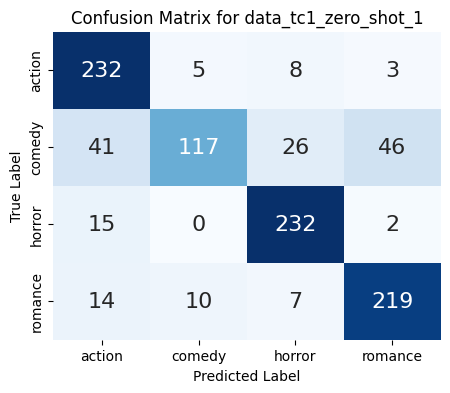

In [138]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.genre, prediction)

# Define class labels
labels = ["action", "comedy", "horror", "romance"]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {file_name}_{shot_name}_{handle_option}")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/confusion_matrix_{file_name}_{shot_name}_{handle_option}.png")
plt.show()
